In [1]:
import pandas as pd
from sklearn.metrics import classification_report

# Validation set

In [2]:
df_test = pd.read_csv('./nRC-test-set.csv', index_col=0)

In [3]:
df_test

,ids,seq,labels
0,RF00001_AGFK01083378_1_200-82,GGATGCGATCATGTCTGCACTAACACACCGGATCCCATCAGAACTC...,5S_rRNA
1,RF00001_ABIM01030413_1_269-151,GGGTGCGATCATACCAGCACTAATTCACCAGATCCCATCAGAACTC...,5S_rRNA
2,RF00001_FJ968867_1_23-141,GCTTACGGCCACACCGCCTGGATCACGCCCGATCTCGTTTGATCTC...,5S_rRNA
3,RF00001_AFEY01299926_1_3191-3073,AGCTACGGCCATATCACCCTGAACATGCCTGATCTCGTCTGATCTC...,5S_rRNA
4,RF00001_ACYM01068335_1_1131-1013,GGTTGCGTTCATACCAACTCACATGCACCGGATCCCATCTGAACTC...,5S_rRNA
...,...,...,...
2595,RF02535_ABQO010479098_1_2462-2621,AGTGCAACCGCTGCACCGAAGTCACCATCGTAGCCTTGTATCTCAC...,IRES
2596,RF02535_ABQO010931335_1_1612-1466,CAGGGCAGTGGCTGCACTGAAGGCAAAGTCGTAGCCTTGTATTGCA...,IRES
2597,RF02535_ABVD01851849_1_606-739,AGTCCTAAGGCTGCATTGAACAGGACCTGGAATTCCCAGAGAATTG...,IRES
2598,RF02535_AAGU03005870_1_8100-7981,GTTTCCACAGCTGGAGGAAGCCTACAAGTGGAATTTGGAATTCCCG...,IRES


In [4]:
from sklearn.utils import shuffle

df_test = shuffle(df_test)
df_test = df_test.reset_index(drop=True)

In [6]:
df_test

,ids,seq,labels
0,RF00001_AFYH01067693_1_7587-7472,CCATTCAGCTACACCATCCTGGCTCCCAATTTCATCTGATTTCAGA...,5S_rRNA
1,RF00029_CT573071_1_1496898-1496722,GAAAGCCGTGTGCGGGAAAATCGCATGCACGGTTTGAAGAGGGGGC...,Intron_gpII
2,RF00002_DQ279029_1_208-361,AAGTATGAATCACGGGTCTCTTGGCTCTCGCATCGATGAAGAACGC...,5_8S_rRNA
3,RF00001_AFYH01047081_1_1436-1317,TGAAATGTTCAAATCTGTCCTGGGTGTTCCTAATCCCATCTGATCT...,5S_rRNA
4,RF00108_ABRT010272506_1_4668-4577,GGATTGCTTATGACTCCCCAATATAAATTCCTTGGAAGTCTGAACA...,CD-box
...,...,...,...
2595,RF00688_AENI01006114_1_99723-99613,CTTACAGACTTCTTTGGCATTCTGTCCACCTCCTTCTATGTATACA...,miRNA
2596,RF00174_DQ981533_1_2642-2821,TAAATAGAAAATGACAGTTGGGCCGTAATGGCCCCGATGGGAAGGC...,riboswitch
2597,RF00001_AFYH01129356_1_7961-7842,ATAGCCCTGACCACCACCCTGAGGGTGCCTGATCCCATCTGATCTC...,5S_rRNA
2598,RF00001_AFYH01146674_1_1183-1064,GTAAGTTACTAGAAGGCCCTGGGTGTGCCTGAGACCCGGTTGATCT...,5S_rRNA


In [7]:
labels = list(set(list(df_test['labels'])))

In [8]:
labels.sort()

In [9]:
labels

['5S_rRNA',
 '5_8S_rRNA',
 'CD-box',
 'HACA-box',
 'IRES',
 'Intron_gpI',
 'Intron_gpII',
 'leader',
 'miRNA',
 'riboswitch',
 'ribozyme',
 'scaRNA',
 'tRNA']

## Generate tokens

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import numpy as np

In [11]:
def seq_to_3mer(seq_list):
	print('Processing {} sequences'.format(len(seq_list)))
	
	main_list = []
	
	for _, i in enumerate(seq_list):
		# print('type(i): ', type(i))
		# print('type([i]): ', type([i]))
		# print('type(list(i)): ', type(list(i)))
		seq = list(i)
		seq_kmer = []

		for j, _ in enumerate(seq):
			if j < len(seq) - 2:
				seq_kmer.append(seq[j] + seq[j+1] + seq[j+2])
			else:
				continue

		main_list.append(seq_kmer)

	return main_list 

def token_pad(sentences, max_len, prefix):
	print('Zero-padding sequences to {} and tokenizing'.format(max_len))

	with open('./tokenizer-nRC-alltokens.pickle', 'rb') as handle:
		tokenizer = pickle.load(handle)

	tokens = tokenizer.texts_to_sequences(sentences)
	all_pad = pad_sequences(tokens, max_len, padding=prefix)

	return all_pad

def argmax_to_label(predictions):
    
	label_list = ['5.8S_rRNA', '5S_rRNA', 'CD-box', 'HACA-box', 'IRES',
                  'Intron_gpI', 'Intron_gpII', 'leader', 'miRNA', 
                  'riboswitch', 'ribozyme', 'scaRNA', 'tRNA']

	argmax_pred = np.argmax(predictions, axis=1)
	argmax_values = range(13)
	pred_labels = []

	for p in argmax_pred:
		for n, l in zip(argmax_values, label_list):
			if p == n:
				pred_labels.append(l)

	return np.array(pred_labels, dtype='object'), label_list

In [12]:
# Gerar k-mers
X_3mer_test = seq_to_3mer(df_test['seq'])

Processing 2600 sequences


In [13]:
seq_length = []
for x in X_3mer_test:
    seq_length.append(len(x))
    
seq_length.sort()
seq_length[-1]

1180

In [14]:
# Tokenization and zero-padding
X_test = token_pad(X_3mer_test, 1134, 'post')

Zero-padding sequences to 1134 and tokenizing


In [15]:
y_test = np.ravel(df_test['labels'])

In [16]:
print(X_test.shape, y_test.shape)

(2600, 1134) (2600,)


## biLSTM+Attention model

In [17]:
import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)

2.6.0


In [18]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

def predict(model_name, X):
    
    model = keras.models.load_model('./{}/'.format(model_name))
    y_pred_prob = model.predict(X)
    y_pred, label_list = argmax_to_label(y_pred_prob)
    
    return y_pred_prob, y_pred

def get_metrics(y_test, y_pred, y_pred_prob, model_name):
    
    # encoding das classes
    y_test_encode = np.argmax(pd.get_dummies(y_test).values, axis=1)
    y_pred_encode = np.argmax(pd.get_dummies(y_pred).values, axis=1)
    
    print(model_name)
    print('accuracy: {}'.format(balanced_accuracy_score(y_test_encode, y_pred_encode)))
    print('precision: {}'.format(precision_score(y_test_encode, y_pred_encode, average='weighted')))
    print('recall: {}'.format(recall_score(y_test_encode, y_pred_encode, average='weighted')))
    print('f1_score: {}'.format(f1_score(y_test_encode, y_pred_encode, average='weighted')))
    print('MCC: {}'.format(matthews_corrcoef(y_test_encode, y_pred_encode)))
    print('ROC AUC: {}'.format(roc_auc_score(y_test_encode, y_pred_prob, average='macro', multi_class='ovo')))
    
    title = 'nRC validation set'
    plot_cm(y_test_encode, y_pred_encode, None,'.0f', title)

In [19]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report,
							 confusion_matrix,
							 roc_auc_score)

label_list = ['5.8S-rRNA', '5S-rRNA', 'CD-box', 'HACA-box', 'IRES',
              'Intron-gp-I', 'Intron-gp-II', 'Leader', 'miRNA', 
              'Riboswitch', 'Ribozyme', 'scaRNA', 'tRNA']


def plot_cm(labels, argmax_prediction, normalize, fmt, title):
    cm = confusion_matrix(labels, argmax_prediction, normalize=normalize)
    fig = plt.figure(figsize=(10, 8), dpi=150)
    sns.set(font_scale=1.5)
    sns.heatmap(cm, xticklabels=label_list, yticklabels=label_list,
                cmap='Reds', fmt=fmt, square=True, annot=True)
    
    plt.title(title, fontsize=20)
    plt.ylabel("True label", fontsize=19)
    plt.xlabel("Predicted label", fontsize=19)
    #ax = fig.add_subplot(111)
    #plt.set_xticklabels(label_list)
    #plt.set_yticklabels(label_list)
    plt.yticks(rotation='horizontal', fontsize=18)
    plt.xticks(rotation='vertical', fontsize=18)
    plt.show()

biLSTMAtt
accuracy: 0.8788461538461539
precision: 0.8822176170485635
recall: 0.8788461538461538
f1_score: 0.8784303990515596
MCC: 0.8691045388291698
ROC AUC: 0.9872525641025638


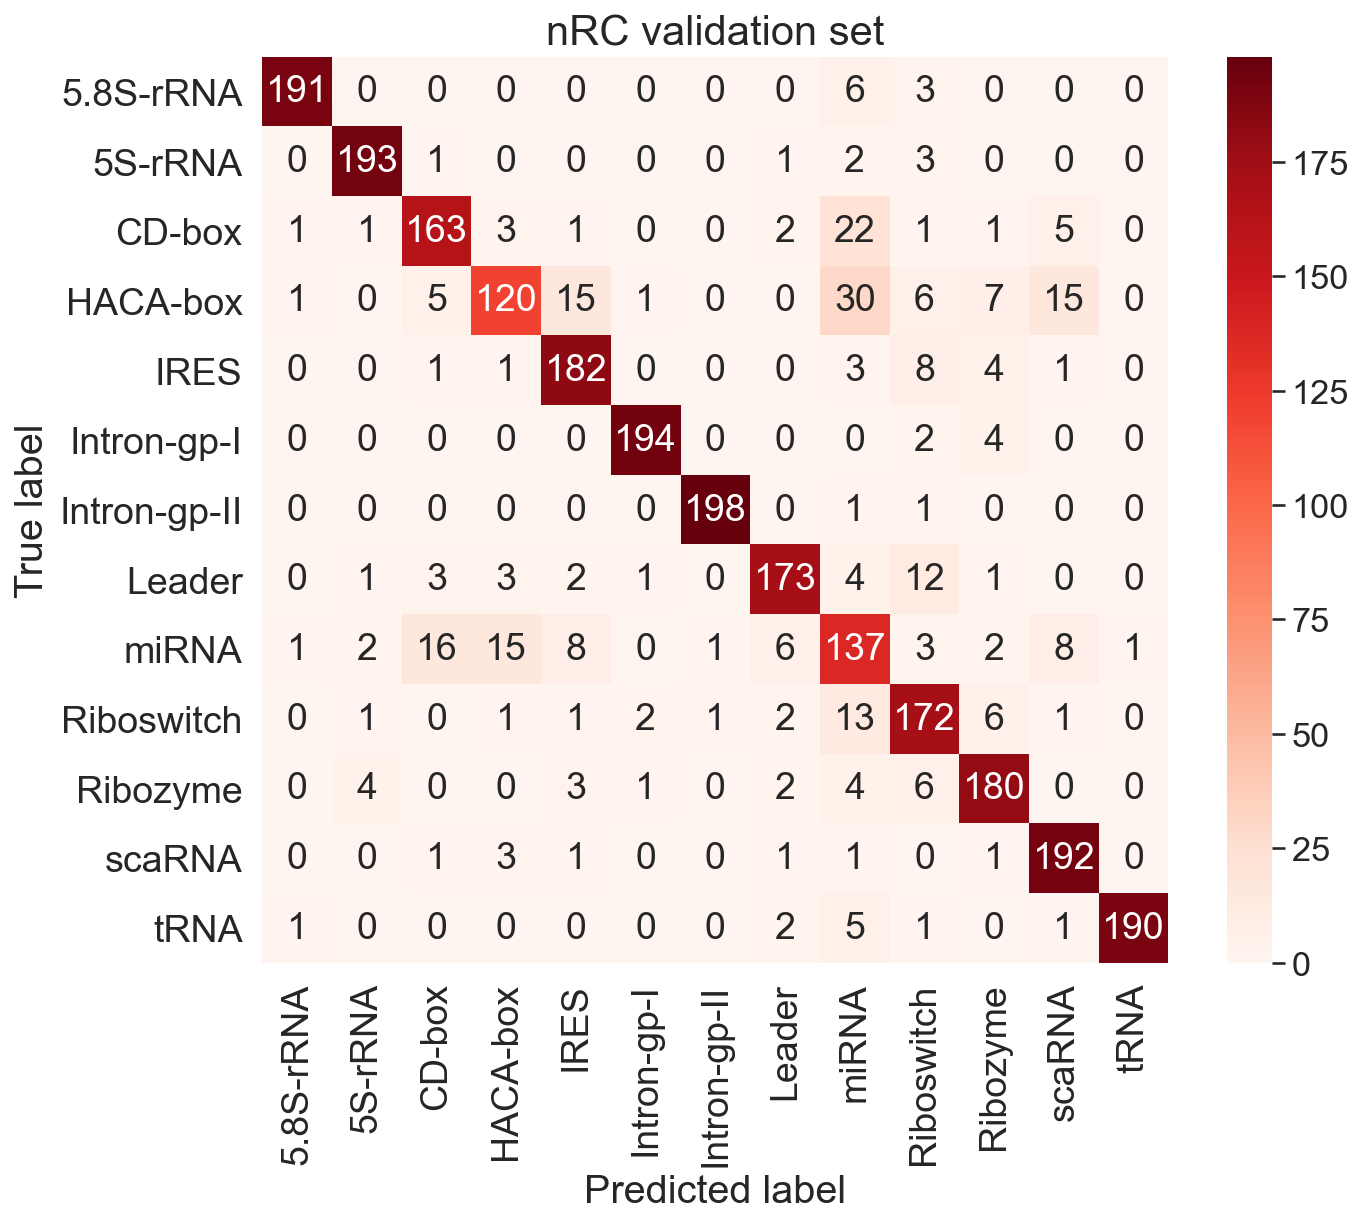

In [20]:
# biLSTMAtt
y_pred_prob, y_pred = predict('biLSTMAtt_fulltraining_nRC-lr0.006-D10-20epochs', X_test)
get_metrics(y_test, y_pred, y_pred_prob, 'biLSTMAtt')

## t-SNE

In [81]:
def plotTSNE(df, p):

    colors = ['r', 'g', 'b', 'c', 'cyan', 'sienna', 'y', 'grey', 'palegreen', 'darkorange', 'lime', 'purple', 'magenta']

    classes = ['5_8S_rRNA', '5S_rRNA', 'CD-box', 'HACA-box', 'IRES',
               'Intron-gpI', 'Intron-gpII', 'leader', 'miRNA', 
               'riboswitch', 'ribozyme', 'scaRNA', 'tRNA']
    
    plt.figure(figsize=(10, 8), dpi=150)
    
    for target, color in zip(classes, colors):
        indicesToKeep = output['true'] == target
    
        plt.scatter(df.loc[indicesToKeep, 'X']
                   , df.loc[indicesToKeep, 'Y']
                   , c = color
                   , s = 60
                   , alpha=0.9
                   , edgecolors='black'
                   , linewidths=0.6)
        
    plt.title('Perplexity: {}'.format(p), fontsize=20)
    plt.xlabel('X', fontsize=20)
    plt.ylabel('Y', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.tick_params(axis='both', which='minor', labelsize=18)
    plt.legend(classes, fontsize=18, loc='upper right', bbox_to_anchor=(2.8, 1),
         ncol=4, fancybox=True, shadow=True, markerscale=2)

In [24]:
import tensorflow as tf

def Predict(model, X):
    
    """ Classify a sequence of tokens and output the attention distribution """
    
    # input: model, data, attention layer index, output distrbution from attention layer
    
    predictions = tf.keras.Model(inputs = model.input, 
                                 outputs = [model.output,
                                            model.layers[3].output[0],
                                            model.layers[3].output[1]])
    
    output, context, weights = predictions.predict(X)
    #weights = tf.squeeze(weights, 1)
    #context = tf.squeeze(context, 1)
    
    # return as dataframe
    new_df = pd.DataFrame()
    new_df['prediction'] = np.argmax(output, axis=1)
    new_df['c_vector'] = list(context)
    #new_df['weights'] = weights
    
    return new_df

In [25]:
biLSTMAtt = keras.models.load_model('./biLSTMAtt_fulltraining_nRC-lr0.006-D10-20epochs/')

In [26]:
output = Predict(biLSTMAtt, X_test)

In [27]:
output['true'] = list(df_test['labels'])

In [33]:
len(output.c_vector[0])

256

In [34]:
output[list(range(256))] = pd.DataFrame(output.c_vector.tolist(), index= output.index)

In [35]:
c = output.iloc[:, 3:]

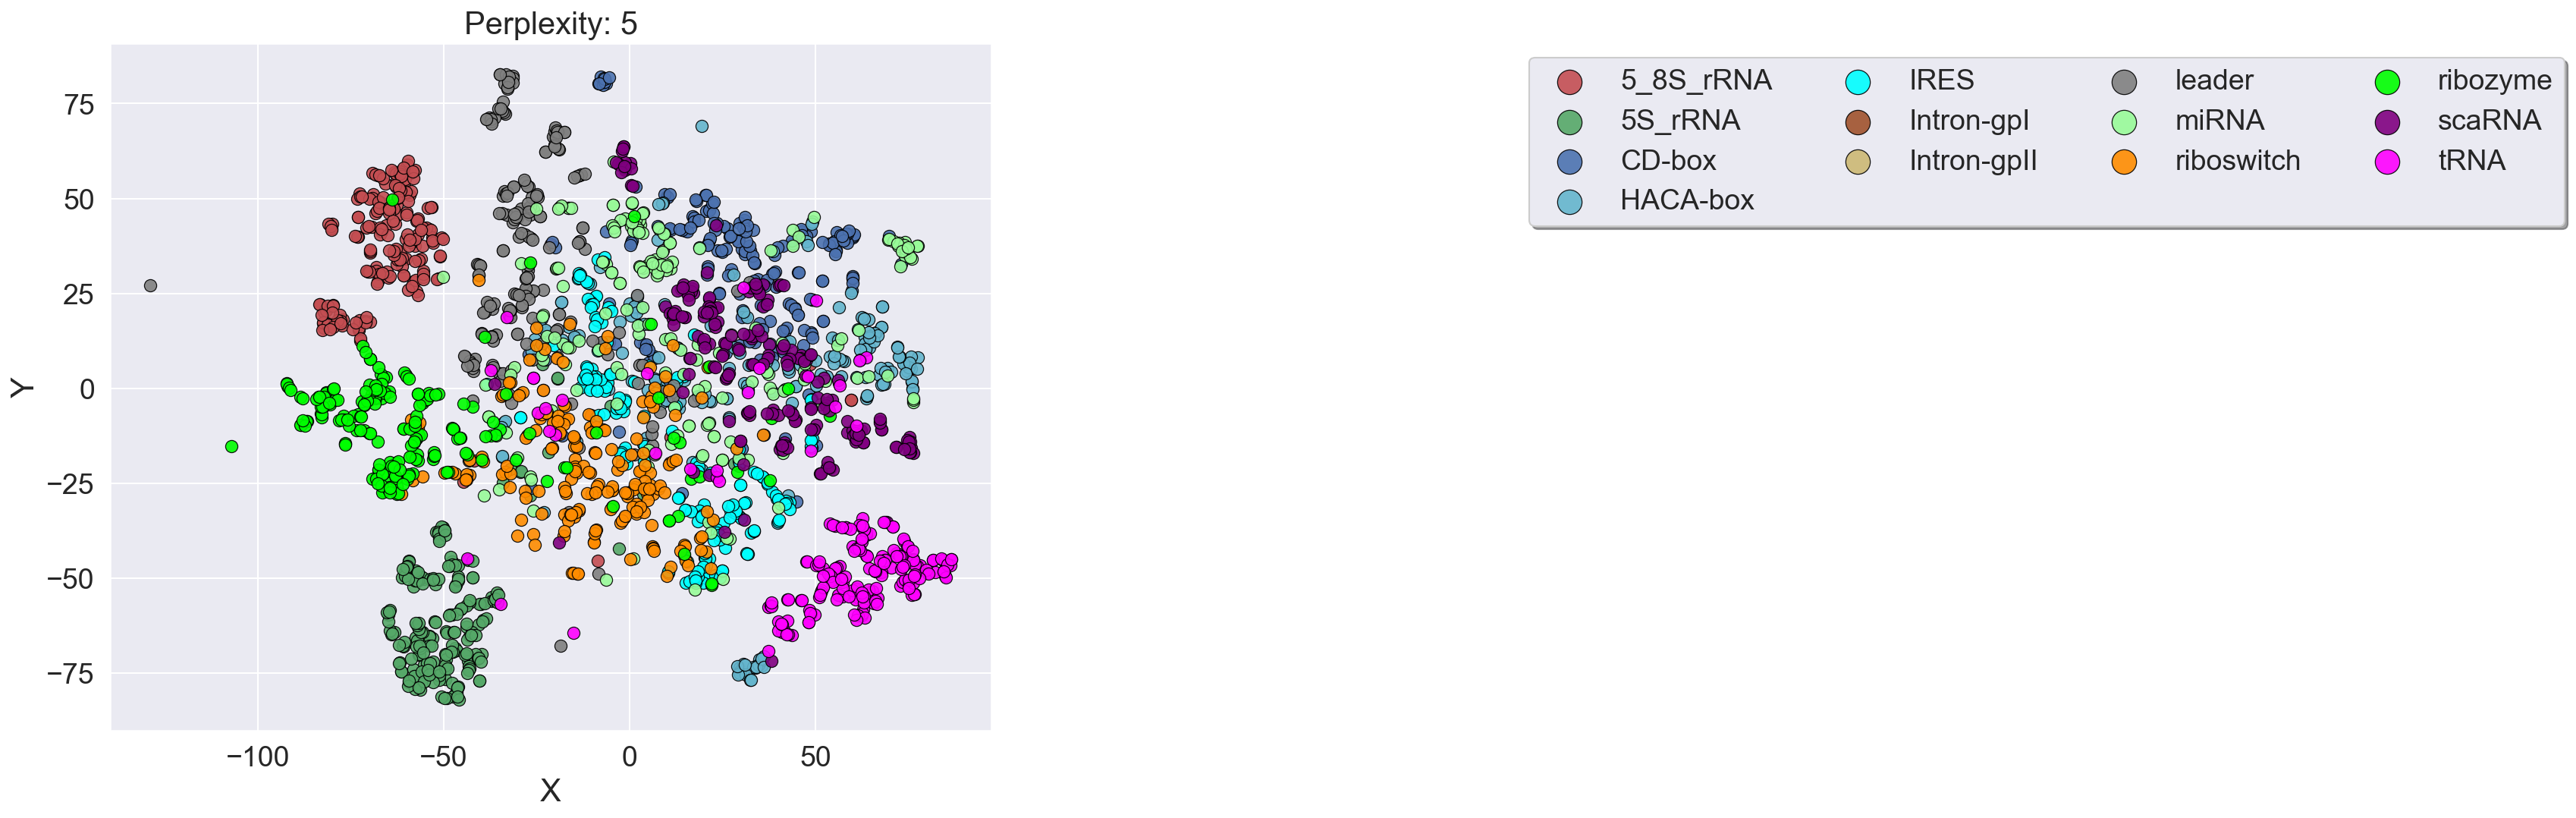

In [82]:
from sklearn.manifold import TSNE

perplexities = [5]

for p in perplexities:

    X_embedded = TSNE(n_components=2, perplexity=p, init='pca', n_jobs=2).fit_transform(c)

    df_tsne = pd.DataFrame(data = X_embedded,
                           columns = ['X', 'Y'])

    #df_tsne['prediction'] = output['prediction']
    #df_tsne.to_csv('./nRC-validation-set-tSNE-p{}-3components-afterPCA.csv'.format(p))
    
    plotTSNE(df_tsne, p)